In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from scipy.interpolate import griddata
import pandas as pd
import geopandas as gpd
import contextily as ctx

#purple_df = pd.read_csv('/Users/jenniferbadger/Documents/GitHub/229project/final_frame.csv', index_col=None,encoding='UTF-8', delimiter=',')
purple_df = pd.read_csv('/Users/katie/Documents/GitHub/229project/final_frame.csv', index_col=None,encoding='UTF-8', delimiter=',')

#purple_df.drop(['Unnamed: 0'])
purple_df['PM2.5 CF1 Mean'].mean() #94.5
purple_df['PM2.5 CF1 Mean'].max() #4475! 
purple_df['PM2.5 CF1 Mean'].min() #0.064
purple_df['PM2.5 CF1 Mean'].median() #15.9

#Trimming data for outliers or potentially uncalibrated sensors
purple_trim = purple_df[purple_df['PM2.5 CF1 Mean']< 30]
purple_trim = purple_trim[purple_df['PM2.5 CF1 Mean']> 5]
purple_trim.head()
#purple_df.head()

<ipython-input-1-929421d8cd42>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  purple_trim = purple_trim[purple_df['PM2.5 CF1 Mean']> 5]


Unnamed: 0               created_at  \
0           0  2019-03-16 00:00:00 UTC   
1           1  2019-03-16 00:00:00 UTC   
2           2  2019-03-26 00:00:00 UTC   
3           3  2019-03-27 00:00:00 UTC   
4           4  2019-01-09 00:00:00 UTC   

                                            filename        lat        long  \
0  CCA 61st and King (outside) (33.98329 -118.183...  33.983290 -118.183926   
1  CCA 52nd Dr and Heliotrope (outside) (33.98995...  33.989950 -118.178093   
2  Adams Square (inside) (inside) (34.133594 -118...  34.133594 -118.241213   
3  CSUN Live Oak (outside) (34.238179 -118.528333...  34.238179 -118.528333   
4  6th St (inside) (34.020076 -118.49534) Primary...  34.020076 -118.495340   

   PM2.5 ATM Mean  PM2.5 CF1 Mean  
0       16.995496       18.172958  
1       16.328882       17.597437  
2       12.812237       14.105855  
3       13.484826       13.641279  
4        6.793395        7.069488

In [2]:
len(purple_df)

110

In [3]:
len(purple_trim)

97

[(-118.7, -117.9), (33.9, 34.25)]

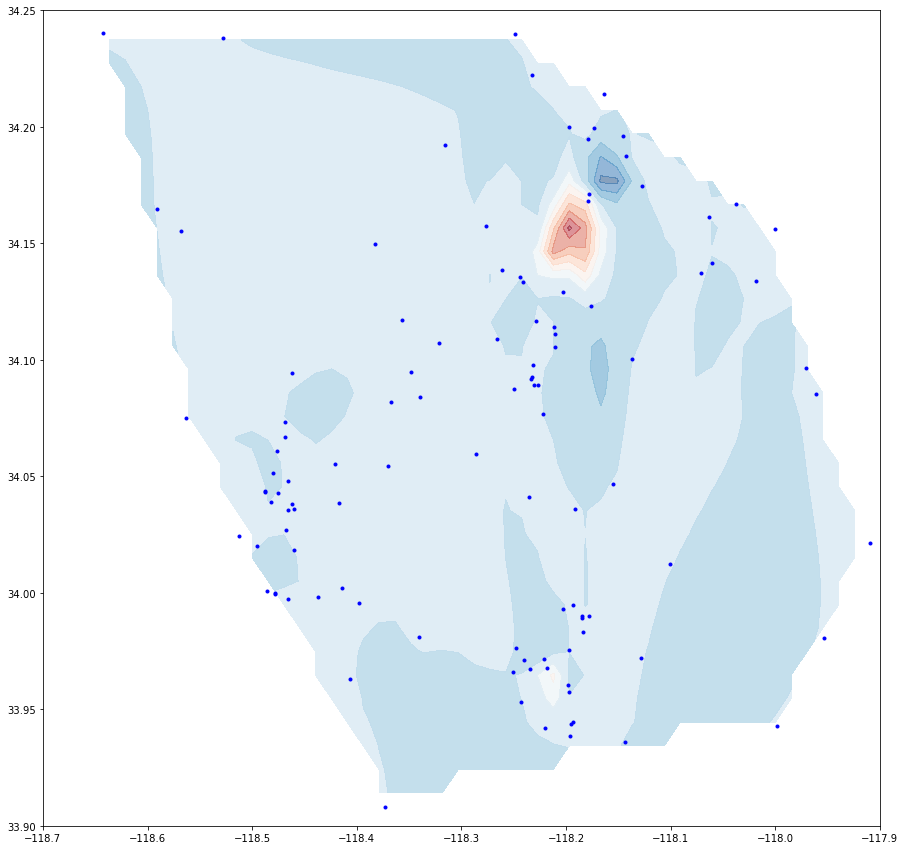

In [4]:
#CONTOUR SURFACE: FIRST ITERATION 

#https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html

xpts = purple_df['long']
ypts = purple_df['lat']
zpts = purple_df['PM2.5 CF1 Mean']

min(xpts) #-118.642964
max(xpts) #-117.90991

min(ypts) #33.907907
max(ypts) #34.240106

#creating the plot
fig, ax = plt.subplots(figsize=(15,15))

#linspace returns evenly spaced numbers over a specified interval
#https://numpy.org/devdocs/reference/generated/numpy.linspace.html
xi = np.linspace(start = -119.0, stop = -117.5, num = 100)
yi = np.linspace(33.5, 34.5, 100)


#xi2 = np.linspace(purple_df['long'].min(), purple_df['long'].max())
#yi2 = np.linspace(purple_df['lat'].min(), purple_df['lat'])

X, Y = np.meshgrid(xi,yi)

#interpolation
#griddata interpolates a surface at the points specified by (xi,yi) to produce zi
#scipy.interpolate.griddata(points, values, xi, method='linear', fill_value=nan, rescale=False)
zi = griddata((xpts, ypts), zpts, (X,Y), method='cubic')

#draws contour lines
ax.contour(zi, levels=10, linewidths=0.15, colors='k')

#fills contours, cmap = colormap, alpha = transparency
contour = ax.contourf(xi, yi, zi, levels=10, cmap = "RdBu_r",  alpha = 0.5)

#plots lat/long using bo= blue circle markers
ax.plot(xpts, ypts, 'bo', markersize = 3)
ax.set(xlim=(-118.7, -117.9), ylim=(33.9, 34.25))

In [5]:
#Defining x and y pts in terms of projection 4326
purple_trim_gdf = gpd.GeoDataFrame(
    purple_trim, geometry = gpd.points_from_xy(purple_trim.long, purple_trim.lat, crs='EPSG:4326'))
purple_trim_gdf.head()

Unnamed: 0               created_at  \
0           0  2019-03-16 00:00:00 UTC   
1           1  2019-03-16 00:00:00 UTC   
2           2  2019-03-26 00:00:00 UTC   
3           3  2019-03-27 00:00:00 UTC   
4           4  2019-01-09 00:00:00 UTC   

                                            filename        lat        long  \
0  CCA 61st and King (outside) (33.98329 -118.183...  33.983290 -118.183926   
1  CCA 52nd Dr and Heliotrope (outside) (33.98995...  33.989950 -118.178093   
2  Adams Square (inside) (inside) (34.133594 -118...  34.133594 -118.241213   
3  CSUN Live Oak (outside) (34.238179 -118.528333...  34.238179 -118.528333   
4  6th St (inside) (34.020076 -118.49534) Primary...  34.020076 -118.495340   

   PM2.5 ATM Mean  PM2.5 CF1 Mean                     geometry  
0       16.995496       18.172958  POINT (-118.18393 33.98329)  
1       16.328882       17.597437  POINT (-118.17809 33.98995)  
2       12.812237       14.105855  POINT (-118.24121 34.13359)  
3       13.484826       13.641279  POINT (-118.52833 34.23818)  
4        6.793395        7.069488  POINT (-118.49534 34.02008)

In [6]:
#converting gdf with projected coordinates back into df
purple_trim_proj= purple_trim_gdf

#converting geometry column into individual lat/long
purple_trim_proj['lat proj'] = purple_trim_gdf.geometry.apply(lambda x: x.y)

purple_trim_proj['long proj'] = purple_trim_gdf.geometry.apply(lambda x: x.x)

#dropping column
purple_trim_proj = purple_trim_proj.drop(['latproj'], axis = 1)

purple_trim_proj.head()

KeyError: "['latproj'] not found in axis"

[(-118.7, -117.9), (33.9, 34.25)]

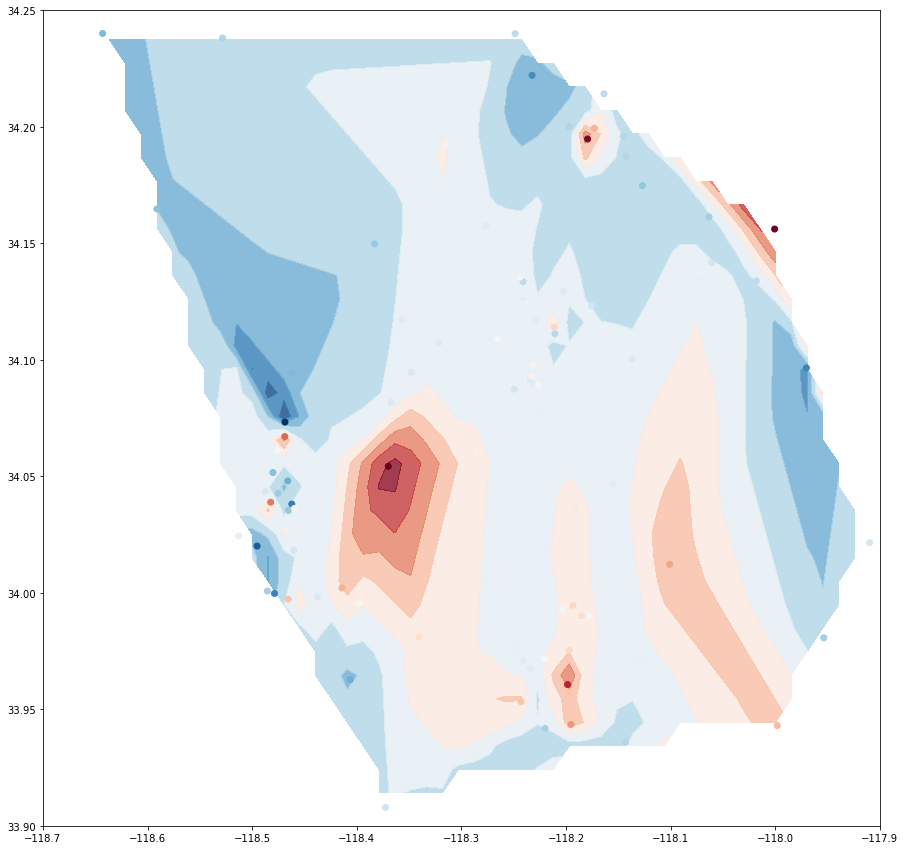

In [7]:
#CONTOUR SURFACE: FINAL ITERATION 

xpts = purple_trim_proj['long proj']
ypts = purple_trim_proj['lat proj']
zpts = purple_trim_proj['PM2.5 CF1 Mean']

min(xpts) #-118.642964
max(xpts) #-117.90991

min(ypts) #33.907907
max(ypts) #34.240106

#creating the plot
fig, ax = plt.subplots(figsize=(15,15))

#linspace returns evenly spaced numbers over a specified interval
#https://numpy.org/devdocs/reference/generated/numpy.linspace.html
xi = np.linspace(start = -119.0, stop = -117.5, num = 100)
yi = np.linspace(33.5, 34.5, 100)

# meshgrid creates a rectangular grid out of an array of x values and an array of y values.
X, Y = np.meshgrid(xi,yi)

#interpolation
#griddata interpolates a surface at the points specified by (xi,yi) to produce zi
#scipy.interpolate.griddata(points, values, xi, method='linear', fill_value=nan, rescale=False)
zi = griddata((xpts, ypts), zpts, (X,Y), method='linear')
                       
#draws contour lines
ax.contour(zi, levels=10, linewidths= 1.5, colors='k')

#fills contours, cmap = colormap, alpha = transparency
contour = ax.contourf(xi, yi, zi, levels=10, cmap = "RdBu_r",  alpha = 0.8)

#plots sensor locations using bo= blue circle markers
#ax.plot(xpts, ypts, 'bo', markersize = 3)

#plots sensor locations with colormap expressing pm2.5 mean gradients
scatter = ax.scatter(xpts, ypts, c = zpts ,cmap = "RdBu_r")
#setting the axes
ax.set(xlim=(-118.7, -117.9), ylim=(33.9, 34.25))


In [8]:
zpts

0      18.172958
1      17.597437
2      14.105855
3      13.641279
4       7.069488
         ...    
105    20.615290
106    19.214658
107    29.090000
108    17.884022
109    28.615000
Name: PM2.5 CF1 Mean, Length: 97, dtype: float64

In [9]:
#saving the fig
#fig.savefig('contour_scatter.png')

#fig.savefig('contour.png')

In [10]:
#checking interpolated value array
len(zi) #1128

100

In [11]:
print(zi) # zi looks like a bunch of nans

np.count_nonzero(np.isnan(zi)) #8872
np.isnan(zi).sum() #returns 8872

np.count_nonzero(~np.isnan(zi)) #1128 values

#zi total = 10000 values
#approximately 10% of the nodes have predicted pm 2.5 values

#has to do with points being outside of convex hull
#https://stackoverflow.com/questions/37643934/nan-values-are-from-griddata

zi_df = pd.DataFrame(zi)
zi_df.head()

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


0   1   2   3   4   5   6   7   8   9   ...  90  91  92  93  94  95  96  \
0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
1 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
2 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
3 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
4 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   

   97  98  99  
0 NaN NaN NaN  
1 NaN NaN NaN  
2 NaN NaN NaN  
3 NaN NaN NaN  
4 NaN NaN NaN  

[5 rows x 100 columns]

In [12]:
#checking linspace array
len(xi) #100
xi #returns a reasonable looking array


array([-119.        , -118.98484848, -118.96969697, -118.95454545,
       -118.93939394, -118.92424242, -118.90909091, -118.89393939,
       -118.87878788, -118.86363636, -118.84848485, -118.83333333,
       -118.81818182, -118.8030303 , -118.78787879, -118.77272727,
       -118.75757576, -118.74242424, -118.72727273, -118.71212121,
       -118.6969697 , -118.68181818, -118.66666667, -118.65151515,
       -118.63636364, -118.62121212, -118.60606061, -118.59090909,
       -118.57575758, -118.56060606, -118.54545455, -118.53030303,
       -118.51515152, -118.5       , -118.48484848, -118.46969697,
       -118.45454545, -118.43939394, -118.42424242, -118.40909091,
       -118.39393939, -118.37878788, -118.36363636, -118.34848485,
       -118.33333333, -118.31818182, -118.3030303 , -118.28787879,
       -118.27272727, -118.25757576, -118.24242424, -118.22727273,
       -118.21212121, -118.1969697 , -118.18181818, -118.16666667,
       -118.15151515, -118.13636364, -118.12121212, -118.10606

In [13]:
#checking linspace array
len(yi) #100
yi #returns a reasonable looking array

array([33.5       , 33.51010101, 33.52020202, 33.53030303, 33.54040404,
       33.55050505, 33.56060606, 33.57070707, 33.58080808, 33.59090909,
       33.6010101 , 33.61111111, 33.62121212, 33.63131313, 33.64141414,
       33.65151515, 33.66161616, 33.67171717, 33.68181818, 33.69191919,
       33.7020202 , 33.71212121, 33.72222222, 33.73232323, 33.74242424,
       33.75252525, 33.76262626, 33.77272727, 33.78282828, 33.79292929,
       33.8030303 , 33.81313131, 33.82323232, 33.83333333, 33.84343434,
       33.85353535, 33.86363636, 33.87373737, 33.88383838, 33.89393939,
       33.9040404 , 33.91414141, 33.92424242, 33.93434343, 33.94444444,
       33.95454545, 33.96464646, 33.97474747, 33.98484848, 33.99494949,
       34.00505051, 34.01515152, 34.02525253, 34.03535354, 34.04545455,
       34.05555556, 34.06565657, 34.07575758, 34.08585859, 34.0959596 ,
       34.10606061, 34.11616162, 34.12626263, 34.13636364, 34.14646465,
       34.15656566, 34.16666667, 34.17676768, 34.18686869, 34.19

In [18]:
zi_df

0   1   2   3   4   5   6   7   8   9   ...  90  91  92  93  94  95  96  \
0  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
1  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
2  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
3  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
4  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
5  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
6  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
7  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
8  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
9  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
10 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
11 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
12 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
13 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
14 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
16 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
17 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
18 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
19 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
20 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
21 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
22 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
23 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
24 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
25 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
26 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
27 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
28 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
29 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
30 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
31 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
32 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
33 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
34 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
35 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
36 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
37 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
38 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
39 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
40 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
41 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
42 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
43 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
44 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
45 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
46 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
47 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
48 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
49 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN Na

In [47]:
pd.set_option('display.max_rows', 10000)
aqdf = zi_df.melt().reset_index()
aqdf.rename(columns={'index':'y','variable':'x','value':'Avg PM 2.5'},inplace=True)

In [48]:
yseries = pd.Series(range(0,100))
aqdf.y = pd.concat([yseries]*100, ignore_index=True)
aqdf

y   x  Avg PM 2.5
0      0   0         NaN
1      1   0         NaN
2      2   0         NaN
3      3   0         NaN
4      4   0         NaN
5      5   0         NaN
6      6   0         NaN
7      7   0         NaN
8      8   0         NaN
9      9   0         NaN
10    10   0         NaN
11    11   0         NaN
12    12   0         NaN
13    13   0         NaN
14    14   0         NaN
15    15   0         NaN
16    16   0         NaN
17    17   0         NaN
18    18   0         NaN
19    19   0         NaN
20    20   0         NaN
21    21   0         NaN
22    22   0         NaN
23    23   0         NaN
24    24   0         NaN
25    25   0         NaN
26    26   0         NaN
27    27   0         NaN
28    28   0         NaN
29    29   0         NaN
30    30   0         NaN
31    31   0         NaN
32    32   0         NaN
33    33   0         NaN
34    34   0         NaN
35    35   0         NaN
36    36   0         NaN
37    37   0         NaN
38    38   0         NaN
39    39   0         NaN
40    40   0         NaN
41    41   0         NaN
42    42   0         NaN
43    43   0         NaN
44    44   0         NaN
45    45   0         NaN
46    46   0         NaN
47    47   0         NaN
48    48   0         NaN
49    49   0         NaN
50    50   0         NaN
51    51   0         NaN
52    52   0         NaN
53    53   0         NaN
54    54   0         NaN
55    55   0         NaN
56    56   0         NaN
57    57   0         NaN
58    58   0         NaN
59    59   0         NaN
60    60   0         NaN
61    61   0         NaN
62    62   0         NaN
63    63   0         NaN
64    64   0         NaN
65    65   0         NaN
66    66   0         NaN
67    67   0         NaN
68    68   0         NaN
69    69   0         NaN
70    70   0         NaN
71    71   0         NaN
72    72   0         NaN
73    73   0         NaN
74    74   0         NaN
75    75   0         NaN
76    76   0         NaN
77    77   0         NaN
78    78   0         NaN
79    79   0         NaN
80    80   0         NaN
81    81   0         NaN
82    82   0         NaN
83    83   0         NaN
84    84   0         NaN
85    85   0         NaN
86    86   0         NaN
87    87   0         NaN
88    88   0         NaN
89    89   0         NaN
90    90   0         NaN
91    91   0         NaN
92    92   0         NaN
93    93   0         NaN
94    94   0         NaN
95    95   0         NaN
96    96   0         NaN
97    97   0         NaN
98    98   0         NaN
99    99   0         NaN
100    0   1         NaN
101    1   1         NaN
102    2   1         NaN
103    3   1         NaN
104    4   1         NaN
105    5   1         NaN
106    6   1         NaN
107    7   1         NaN
108    8   1         NaN
109    9   1         NaN
110   10   1         NaN
111   11   1         NaN
112   12   1         NaN
113   13   1         NaN
114   14   1         NaN
115   15   1         NaN
116   16   1         NaN
117   17   1         NaN
118   18   1         NaN
119   19   1         NaN
120   20   1         NaN
121   21   1         NaN
122   22   1         NaN
123   23   1         NaN
124   24   1         NaN
125   25   1         NaN
126   26   1         NaN
127   27   1         NaN
128   28   1         NaN
129   29   1         NaN
130   30   1         NaN
131   31   1         NaN
132   32   1         NaN
133   33   1         NaN
134   34   1         NaN
135   35   1         NaN
136   36   1         NaN
137   37   1         NaN
138   38   1         NaN
139   39   1         NaN
140   40   1         NaN
141   41   1         NaN
142   42   1         NaN
143   43   1         NaN
144   44   1         NaN
145   45   1         NaN
146   46   1         NaN
147   47   1         NaN
148   48   1         NaN
149   49   1         NaN
150   50   1         NaN
151   51   1         NaN
152   52   1         NaN
153   53   1         NaN
154   54   1         NaN
155   55   1         NaN
156   56   1         NaN
157   57   1         NaN
158   58   1         NaN
159   5

In [49]:
aqdf['x'] = aqdf['x'].astype(int)
aqdf['y'] = aqdf['y'].astype(int)

In [50]:
aqdf['lat'] = aqdf['x']*0.01515152-119
aqdf['long'] = aqdf['y']*0.01010101+33.5

In [78]:
aqgdf = gpd.GeoDataFrame(aqdf, geometry=gpd.points_from_xy(aqdf.lat,aqdf.long, crs='EPSG:4326'))

In [79]:
aqgdf = aqgdf.dropna(subset=['Avg PM 2.5'])
aqgdf = aqgdf.drop(['y', 'x', 'lat','long'], axis = 1)

In [80]:
aqgdf.shape

(1113, 2)

In [81]:
aqgdf

Avg PM 2.5                     geometry
2473   11.965019  POINT (-118.63636 34.23737)
2570   12.210090  POINT (-118.62121 34.20707)
2571   12.078555  POINT (-118.62121 34.21717)
2572   12.138999  POINT (-118.62121 34.22727)
2573   12.199442  POINT (-118.62121 34.23737)
2668   12.131647  POINT (-118.60606 34.18687)
2669   12.192090  POINT (-118.60606 34.19697)
2670   12.252534  POINT (-118.60606 34.20707)
2671   12.312978  POINT (-118.60606 34.21717)
2672   12.373422  POINT (-118.60606 34.22727)
2673   12.433865  POINT (-118.60606 34.23737)
2765   13.254474  POINT (-118.59091 34.15657)
2766   12.245182  POINT (-118.59091 34.16667)
2767   12.305626  POINT (-118.59091 34.17677)
2768   12.366070  POINT (-118.59091 34.18687)
2769   12.426513  POINT (-118.59091 34.19697)
2770   12.486957  POINT (-118.59091 34.20707)
2771   12.547401  POINT (-118.59091 34.21717)
2772   12.607845  POINT (-118.59091 34.22727)
2773   12.668288  POINT (-118.59091 34.23737)
2863   13.119297  POINT (-118.57576 34.13636)
2864   12.928387  POINT (-118.57576 34.14646)
2865   12.188934  POINT (-118.57576 34.15657)
2866   12.338177  POINT (-118.57576 34.16667)
2867   12.487419  POINT (-118.57576 34.17677)
2868   12.600493  POINT (-118.57576 34.18687)
2869   12.660936  POINT (-118.57576 34.19697)
2870   12.721380  POINT (-118.57576 34.20707)
2871   12.781824  POINT (-118.57576 34.21717)
2872   12.842268  POINT (-118.57576 34.22727)
2873   12.902711  POINT (-118.57576 34.23737)
2960   14.298858  POINT (-118.56061 34.10606)
2961   13.737600  POINT (-118.56061 34.11616)
2962   13.637453  POINT (-118.56061 34.12626)
2963   13.537306  POINT (-118.56061 34.13636)
2964   11.702090  POINT (-118.56061 34.14646)
2965   12.267691  POINT (-118.56061 34.15657)
2966   12.416933  POINT (-118.56061 34.16667)
2967   12.566175  POINT (-118.56061 34.17677)
2968   12.715417  POINT (-118.56061 34.18687)
2969   12.864660  POINT (-118.56061 34.19697)
2970   12.955803  POINT (-118.56061 34.20707)
2971   13.016247  POINT (-118.56061 34.21717)
2972   13.076691  POINT (-118.56061 34.22727)
2973   13.137134  POINT (-118.56061 34.23737)
3058   14.546814  POINT (-118.54545 34.08586)
3059   14.446667  POINT (-118.54545 34.09596)
3060   14.346520  POINT (-118.54545 34.10606)
3061   14.246373  POINT (-118.54545 34.11616)
3062   12.468656  POINT (-118.54545 34.12626)
3063   11.158745  POINT (-118.54545 34.13636)
3064   12.197205  POINT (-118.54545 34.14646)
3065   12.346447  POINT (-118.54545 34.15657)
3066   12.495689  POINT (-118.54545 34.16667)
3067   12.644931  POINT (-118.54545 34.17677)
3068   12.794174  POINT (-118.54545 34.18687)
3069   12.943416  POINT (-118.54545 34.19697)
3070   13.092658  POINT (-118.54545 34.20707)
3071   13.241900  POINT (-118.54545 34.21717)
3072   13.311114  POINT (-118.54545 34.22727)
3073   13.371557  POINT (-118.54545 34.23737)
3155   15.356027  POINT (-118.53030 34.05556)
3156   15.255880  POINT (-118.53030 34.06566)
3157   15.155733  POINT (-118.53030 34.07576)
3158   15.055586  POINT (-118.53030 34.08586)
3159   14.955440  POINT (-118.53030 34.09596)
3160   14.855293  POINT (-118.53030 34.10606)
3161   10.786399  POINT (-118.53030 34.11616)
3162   10.615400  POINT (-118.53030 34.12626)
3163   12.126719  POINT (-118.53030 34.13636)
3164   12.275961  POINT (-118.53030 34.14646)
3165   12.425203  POINT (-118.53030 34.15657)
3166   12.574445  POINT (-118.53030 34.16667)
3167   12.723688  POINT (-118.53030 34.17677)
3168   12.872930  POINT (-118.53030 34.18687)
3169   13.022172  POINT (-118.53030 34.19697)
3170   13.171415  POINT (-118.53030 34.20707)
3171   13.320657  POINT (-118.53030 34.21717)
3172   13.469899  POINT (-118.53030 34.22727)
3173   13.605980  POINT (-118.53030 34.23737)
3253   16.065094  POINT (-118.51515 34.03535)
3254   15.964947  POINT (-118.51515 34.04545)
3255   15.864800  POINT (-118.51515 34.05556)
3256   15.764653  POINT (-118.51515 34.06566)
3257   15.664506  POINT (-118.51515 34.07576)
3258   15.564359  POINT (-118.51515 34.08586)
3259

In [82]:
fname = "C:/Users/Katie/Documents/GitHub/229project/CALosAngeles1939.geojson"
holc = gpd.read_file(fname)
holc.head()

name holc_id holc_grade                              area_description_data  \
0  None      A1          A  {'0': 'Los Angeles County', '2': '85 15', '3':...   
1  None     A10          A  {'0': 'Los Angeles County', '2': '90 10', '3':...   
2  None     A11          A  {'0': 'Los Angeles County', '2': '85 5', '3': ...   
3  None     A12          A  {'0': 'Los Angeles County', '2': '95 ', '3': '...   
4  None     A13          A  {'0': 'Los Angeles County', '2': '60 35', '3':...   

                                            geometry  
0  MULTIPOLYGON (((-118.45744 34.15201, -118.4478...  
1  MULTIPOLYGON (((-118.11151 34.18311, -118.1094...  
2  MULTIPOLYGON (((-118.11300 34.15985, -118.1130...  
3  MULTIPOLYGON (((-118.17123 34.12776, -118.1708...  
4  MULTIPOLYGON (((-118.17458 34.14194, -118.1735...

[Text(0.5, 1.0, 'HOLC Neighborhood Grades and Interpolated Surface Locations')]

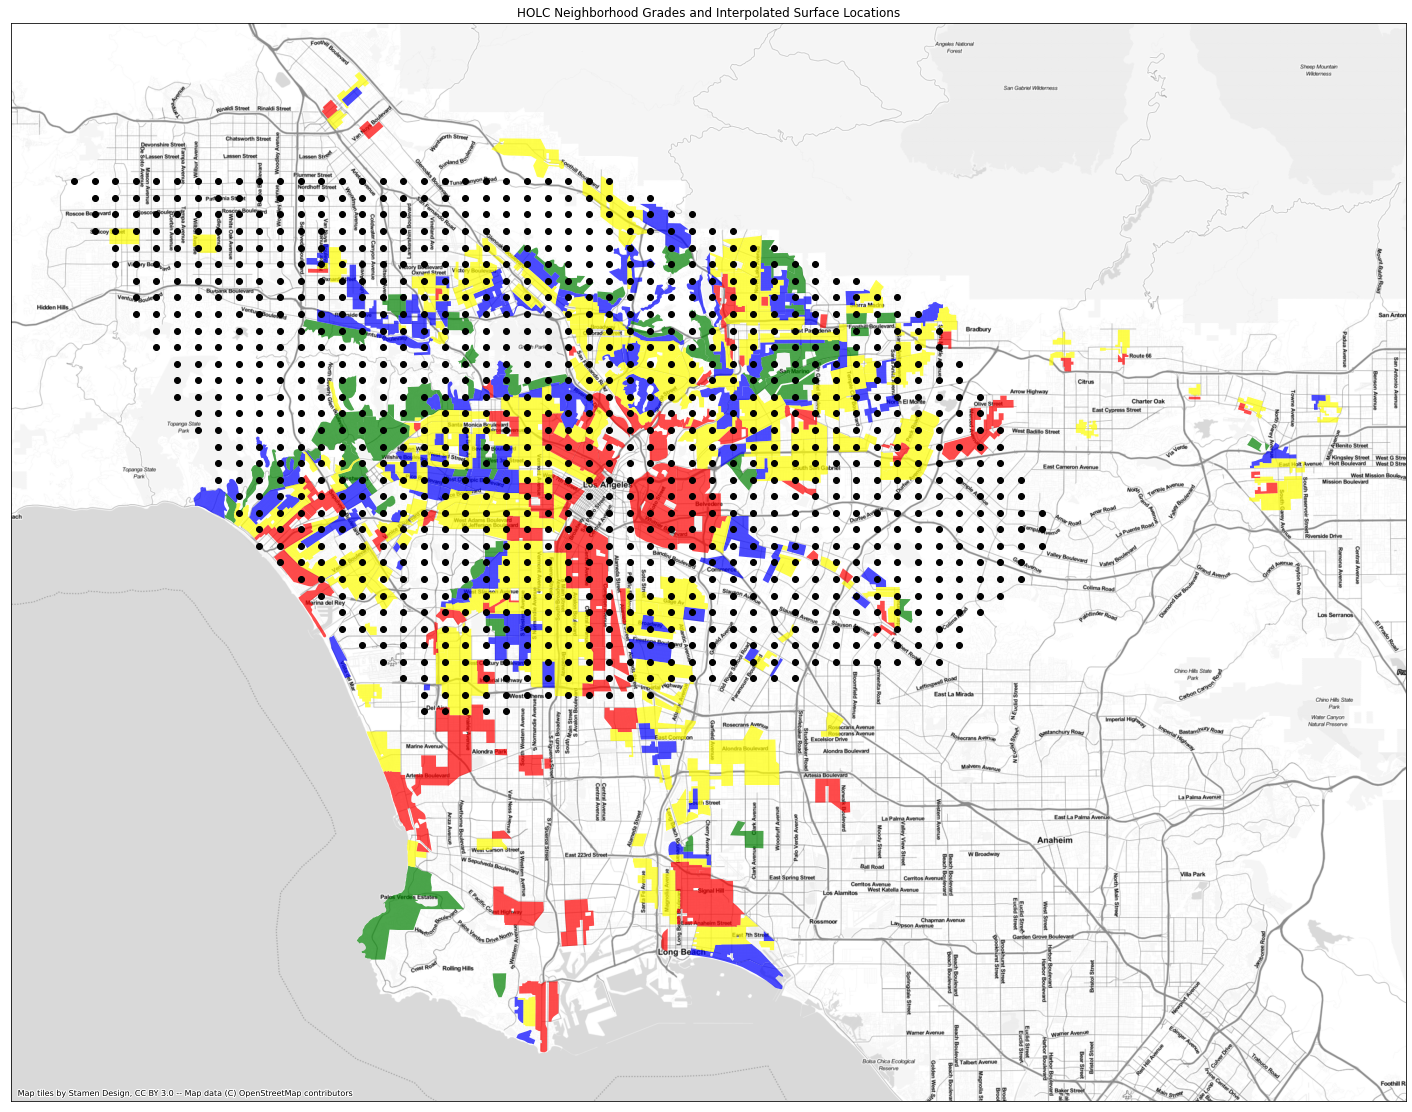

In [83]:
fig, ax = plt.subplots(1,1, figsize=(25,25))
color_mapping = {"A": "green", "B": "blue", "C":"yellow","D":"red"}
holc.to_crs('EPSG:3857').plot(color=holc["holc_grade"].map(color_mapping),legend = True, ax=ax, alpha= 0.7)
aqgdf.to_crs('EPSG:3857').plot(ax=ax, color='black',alpha = 0.99)

ctx.add_basemap(ax, zoom = 12, source = ctx.providers.Stamen.TonerLite)

ax.set_xticks([])
ax.set_yticks([])

ax.set(title='HOLC Neighborhood Grades and Interpolated Surface Locations') 

In [101]:
joindf = gpd.sjoin(holc.to_crs('EPSG:4326'), aqgdf.to_crs('EPSG:4326'), how="left", op='intersects')
joindf.holc_grade = joindf.holc_grade.fillna(value="NA")
joindf

name holc_id holc_grade  \
0    None      A1          A   
0    None      A1          A   
0    None      A1          A   
1    None     A10          A   
2    None     A11          A   
3    None     A12          A   
3    None     A12          A   
4    None     A13          A   
5    None     A14          A   
5    None     A14          A   
6    None     A15          A   
6    None     A15          A   
6    None     A15          A   
7    None     A16          A   
7    None     A16          A   
7    None     A16          A   
8    None     A17          A   
9    None     A18          A   
10   None     A19          A   
11   None      A2          A   
11   None      A2          A   
12   None     A20          A   
13   None     A21          A   
14   None     A22          A   
15   None     A23          A   
16   None     A24          A   
17   None     A25          A   
18   None     A26          A   
19   None     A27          A   
20   None     A28          A   
21   None     A29          A   
22   None      A3          A   
23   None     A30          A   
23   None     A30          A   
23   None     A30          A   
23   None     A30          A   
24   None     A31          A   
25   None     A32          A   
26   None     A33          A   
26   None     A33          A   
27   None     A34          A   
28   None     A35          A   
28   None     A35          A   
28   None     A35          A   
29   None     A36          A   
30   None     A37          A   
30   None     A37          A   
30   None     A37          A   
30   None     A37          A   
31   None     A38          A   
32   None     A39          A   
33   None      A4          A   
33   None      A4          A   
33   None      A4          A   
34   None     A40          A   
35   None     A41          A   
36   None     A42          A   
36   None     A42          A   
37   None     A43          A   
38   None     A46          A   
38   None     A46          A   
39   None     A47          A   
40   None     A48          A   
41   None     A49          A   
42   None      A5          A   
43   None     A50          A   
44   None     A51          A   
45   None     A52          A   
46   None     A53          A   
47   None     A54          A   
48   None     A55          A   
49   None     A56          A   
50   None     A58          A   
51   None     A59          A   
52   None      A6          A   
53   None     A60          A   
54   None      A7          A   
55   None      A8          A   
55   None      A8          A   
56   None      A9          A   
56   None      A9          A   
57   None      B1          B   
58   None     B10          B   
59   None    B100          B   
60   None    B101          B   
60   None    B101          B   
61   None    B102          B   
62   None    B103          B   
63   None    B104          B   
63   None    B104          B   
64   None    B105          B   
65   None    B106          B   
66   None    B107          B   
67   None    B108          B   
68   None    B109          B   
69   None     B11          B   
70   None    B110          B   
71   None    B111          B   
71   None    B111          B   
71   None    B111          B   
72   None    B112          B   
72   None    B112          B   
73   None    B113          B   
74   None    B114          B   
75   None    B115          B   
76   None    B116          B   
77   None    B117          B   
78   None    B118          B   
79   None    B119          B   
80   None     B12          B   
80   None     B12          B   
81   None    B120          B   
82   None    B121          B   
83   None    B122          B   
84   None     B13          B   
85   None     B14          B   
86   None     B15          B   
87   None     B16          B   
87   None     B16          B   
88   None     B17          B   
88   None     B17          B   
89   None     B18          B   
90   None     B19          B   
91   None      B2          B   
92   

In [108]:
joindf2 = joindf.groupby(['holc_id']).mean('Avg PM 2.5').reset_index()
joindf2['holc_grade'] = joindf2['holc_id'].str[0]
joindf2.head()

holc_id  index_right  Avg PM 2.5 holc_grade
0      A1       3764.0   12.595243          A
1     A10       5967.0   13.250590          A
2     A11       5965.0   14.205941          A
3     A12       5514.5   14.357330          A
4     A13       5463.0   14.845122          A

<AxesSubplot:title={'center':'Avg PM 2.5'}, xlabel='holc_grade'>

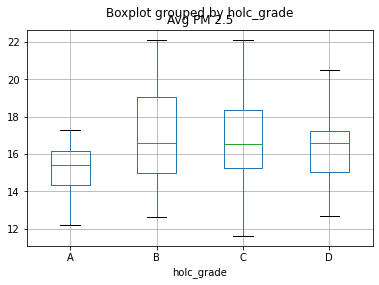

In [103]:
joindf2.boxplot('Avg PM 2.5', by = 'holc_grade', showfliers = False)

<AxesSubplot:title={'center':'Avg PM 2.5'}, xlabel='holc_grade'>

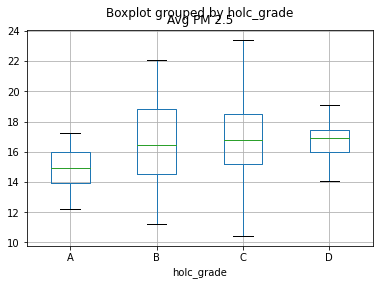

In [104]:
joindf.boxplot('Avg PM 2.5', by = 'holc_grade', showfliers = False)

In [106]:
joindf2.groupby('holc_grade').count()

holc_id  index_right  Avg PM 2.5
holc_grade                                  
A                57           33          33
B               121           63          63
C               167           98          98
D                71           28          28

In [94]:
joindf.groupby('holc_grade').count()

name  holc_id  area_description_data  geometry  index_right  \
holc_grade                                                                
A              0       81                     81        81           57   
B              0      143                    143       143           85   
C              0      271                    271       271          202   
D              0      109                    109       109           66   

            Avg PM 2.5  
holc_grade              
A                   57  
B                   85  
C                  202  
D                   66